In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install mediapipe
!pip install keras-cv
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 34.1 MB/s eta 0:00:00


In [6]:
import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf
import keras_cv
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

# YOLOv8 모델 구성
backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_xs_backbone", include_rescaling=True)

YOLOV8_model = keras_cv.models.YOLOV8Detector(
    num_classes=1,
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=5
)
YOLOV8_model.load_weights('/content/drive/MyDrive/yolo_acne_detection1.weights.h5')
YOLOV8_model.build(input_shape=(None, 640, 640, 3))

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)

part_indices = {
    '이마': [8, 9, 10, 107, 66, 105, 63, 70, 71, 109, 108, 151, 296, 334, 293, 300, 299,
            383, 368, 389, 356, 337, 276, 283, 282, 295, 285, 336]
            + list(range(65, 69)),

    '코': [0, 1, 2, 5, 6, 45, 275, 274, 164, 165, 97, 98, 99,
            2, 94, 240, 218, 219, 220, 237, 218, 134,399, 398],

    '왼쪽볼': [116, 117, 118, 119, 120, 121, 128, 130, 132,
            226, 113, 225, 224, 223, 222, 221, 189, 190, 137, 139, 146],

    '오른쪽볼': [345, 346, 347, 348, 349, 350, 359, 361,
            447, 366, 436, 435, 414, 398, 397]+ list(range(380,390)),

    '턱': [0, 17, 170, 175 ,364, 335, 172, 152, 395, 396, 397,400]
}

def get_part_bounding_box(image, landmarks, indices):
    points = np.array([
        [int(landmarks.landmark[i].x * image.shape[1]),
         int(landmarks.landmark[i].y * image.shape[0])]
        for i in indices
    ])
    x_min, y_min = points.min(axis=0)
    x_max, y_max = points.max(axis=0)
    return x_min, y_min, x_max, y_max

def crop_and_resize(image, bbox):
    x_min, y_min, x_max, y_max = bbox
    cropped = image[y_min:y_max, x_min:x_max]
    resized = cv2.resize(cropped, (640, 640))
    return resized, (x_min, y_min, x_max, y_max), cropped.shape[:2]

def load_test_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"이미지 로드 실패: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def get_yolo_predictions(model, img, threshold=0.4): # threshold 지정
    img_tensor = tf.expand_dims(tf.cast(img, tf.float32), axis=0)
    y_pred = model.predict(img_tensor, verbose=0)

    # 예측 결과에서 bounding box, class, confidence score 가져오기
    boxes, classes, scores = y_pred["boxes"], y_pred["classes"], y_pred["confidence"]

    # 신뢰도 점수 0.4 이상이고 class_id가 0인 박스만 필터링
    filtered_boxes = [
        box for box, cls, score in zip(boxes[0], classes[0], scores[0]) if cls == 0 and score >= threshold
    ]

    return filtered_boxes


def resize_boxes_to_original(boxes, cropped_size, orig_bbox):
    crop_h, crop_w = cropped_size
    x_min, y_min, _, _ = orig_bbox
    scale_x, scale_y = crop_w / 640, crop_h / 640

    resized_boxes = []
    for x1, y1, x2, y2 in boxes:
        resized_boxes.append([
            x_min + x1 * scale_x,
            y_min + y1 * scale_y,
            x_min + x2 * scale_x,
            y_min + y2 * scale_y
        ])
    return resized_boxes

def analyze_acne_by_parts_result(image_path):
    img = load_test_image(image_path)

    results = face_mesh.process(img)
    if not results.multi_face_landmarks:
        print("얼굴 인식 실패")
        return img, None, None, None

    face_landmarks = results.multi_face_landmarks[0]
    part_acne_map = {part: False for part in part_indices.keys()}
    acne_boxes_by_part = {part: [] for part in part_indices.keys()}

    for part, indices in part_indices.items():
        bbox = get_part_bounding_box(img, face_landmarks, indices)
        resized_img, orig_bbox, cropped_size = crop_and_resize(img, bbox)

        acne_boxes = get_yolo_predictions(YOLOV8_model, resized_img, threshold=0.4) # threshold 지정
        acne_boxes = resize_boxes_to_original(acne_boxes, cropped_size, orig_bbox)

        if acne_boxes:
            part_acne_map[part] = True
            acne_boxes_by_part[part] = acne_boxes

    print("\n부위별 여드름 탐지 결과")
    total_acne_count = 0  # 총 탐지된 여드름 개수

    for part, has_acne in part_acne_map.items():
        acne_count = len(acne_boxes_by_part[part])  # 탐지된 여드름 개수
        total_acne_count += acne_count  # 전체 개수 누적

        if has_acne:
            print(f"  {part}: 있음 ({acne_count}개)")
        else:
            print(f"  {part}: 없음")

    if total_acne_count > 0:
        print(f"\n✅ 총 탐지된 여드름 개수: {total_acne_count}개")
    else:
        print("\n✅ 여드름이 탐지되지 않았습니다.")

    return img, face_landmarks, part_acne_map, acne_boxes_by_part


# 테스트 실행
image_path = '/content/drive/MyDrive/여드름1.jpg'
img, face_landmarks, part_acne_map, acne_boxes_by_part = analyze_acne_by_parts_result(image_path)



/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_718']
Received: inputs=Tensor(shape=(1, 640, 640, 3))
  warnings.warn(msg)



부위별 여드름 탐지 결과
  이마: 없음
  코: 있음 (1개)
  왼쪽볼: 없음
  오른쪽볼: 없음
  턱: 없음

✅ 총 탐지된 여드름 개수: 1개


In [13]:
def analyze_acne_by_parts_result(image_path):
    img = load_test_image(image_path)

    results = face_mesh.process(img)
    if not results.multi_face_landmarks:
        print("얼굴 인식 실패")
        return img, None, None, None

    face_landmarks = results.multi_face_landmarks[0]
    part_acne_map = {part: False for part in part_indices.keys()}
    acne_boxes_by_part = {part: [] for part in part_indices.keys()}

    for part, indices in part_indices.items():
        bbox = get_part_bounding_box(img, face_landmarks, indices)
        resized_img, orig_bbox, cropped_size = crop_and_resize(img, bbox)

        acne_boxes = get_yolo_predictions(YOLOV8_model, resized_img, threshold=0.4)
        acne_boxes = resize_boxes_to_original(acne_boxes, cropped_size, orig_bbox)

        if acne_boxes:
            part_acne_map[part] = True
            acne_boxes_by_part[part] = acne_boxes

    print("여드름 탐지 결과")
    total_acne_count = 0  # 총 탐지된 여드름 개수
    acne_count_by_part = {}  # 부위별 여드름 개수 저장

    for part, has_acne in part_acne_map.items():
        acne_count = len(acne_boxes_by_part[part])  # 탐지된 여드름 개수
        total_acne_count += acne_count  # 전체 개수 누적
        acne_count_by_part[part] = acne_count  # 부위별 개수 저장

    if total_acne_count > 0:

        # 여드름이 가장 많이 난 부위 찾기
        priority_order = ["이마", "턱", "왼쪽볼", "오른쪽볼", "코"]
        max_acne_count = max(acne_count_by_part.values())

        # 우선순위에 따라 최다 여드름 부위 결정
        max_acne_part = min(
            (part for part, count in acne_count_by_part.items() if count == max_acne_count),
            key=lambda p: priority_order.index(p)
        )

        print(f"가장 여드름이 많은 부위: {max_acne_part}")

    else:
        print("\n여드름이 탐지되지 않았습니다.")

    return img, face_landmarks, part_acne_map, acne_boxes_by_part


# 테스트 실행
image_path = '/content/drive/MyDrive/여드름1.jpg'
img, face_landmarks, part_acne_map, acne_boxes_by_part = analyze_acne_by_parts_result(image_path)


여드름 탐지 결과
가장 여드름이 많은 부위: 코


In [ ]:
import matplotlib.pyplot as plt

def visualize_detected_parts_with_boxes(original_image, face_landmarks, part_indices, detected_parts, acne_boxes_by_part):
    """
    탐지된 부위만 잘라서 여드름 박스와 함께 시각화하는 함수
    - original_image: 원본 얼굴 이미지
    - face_landmarks: Mediapipe에서 검출한 얼굴 랜드마크 정보
    - part_indices: 각 부위별 랜드마크 인덱스
    - detected_parts: 여드름 있는 부위 여부 맵
    - acne_boxes_by_part: 부위별 여드름 박스 좌표들
    """
    for part, indices in part_indices.items():
        if not detected_parts.get(part, False):
            continue  # 여드름 없는 부위는 스킵

        bbox = get_part_bounding_box(original_image, face_landmarks, indices)
        x_min, y_min, x_max, y_max = bbox

        cropped_part = original_image[y_min:y_max, x_min:x_max].copy()

        # 여드름 박스 그리기 (잘린 영역 기준 좌표로 변환해서 그림)
        for box in acne_boxes_by_part.get(part, []):
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(cropped_part, (x1 - x_min, y1 - y_min), (x2 - x_min, y2 - y_min), (255, 0, 0), 2)

        plt.figure(figsize=(4, 4))
        plt.imshow(cropped_part)
        plt.title(f"{part}에 뾰루지 검출")
        plt.axis('off')
        plt.show()



In [ ]:
!sudo apt-get -qq -y install fonts-nanum
!fc-cache -fv
!rm -rf ~/.cache/matplotlib

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache director

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumGothic')

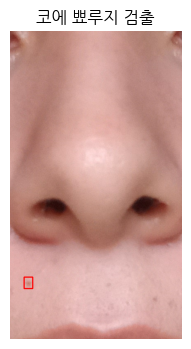

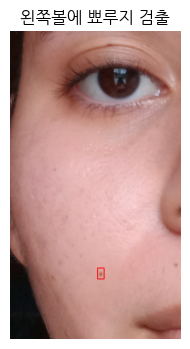

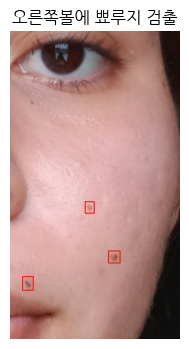

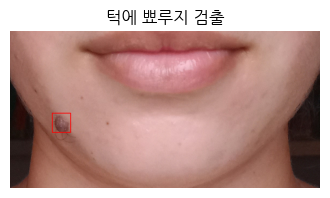

In [ ]:
visualize_detected_parts_with_boxes(img, face_landmarks, part_indices, part_acne_map, acne_boxes_by_part)